In [1]:
#!pip install visualkeras
#!pip install -q keras-nightly
import os
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math
import json
from pathlib import Path
from PIL import Image, ImageChops
import pathlib
import pandas as pd
from pprint import pprint
from skimage import io, color, morphology
from google.colab.patches import cv2_imshow
from google.colab import drive
import imutils
from skimage import morphology
import sys
import re
import json
import imutils
import random
import glob
from google.colab import drive
drive.mount('/content/gdrive')

class NetList:
    # Make a new Netlist and name it using the date and time
    def __init__(self, fileName = "default_netlist"):
        self.netlist = fileName

        # Variable to keep track of number of extra drivers automatically added
        self.driver_node_count = 1

        # Clean up old files
        ext = self.netlist+"_1.*"
        for f in glob.glob(ext):
            os.remove(f)

        ext2 = self.netlist+".*"
        for f in glob.glob(ext2):
            os.remove(f)

        file = open(self.netlist+".net","w")
        file.close()

    # Generate the netlist from matrix representation of circuit
    # con_matrix: connection matrix (list)
    # dev_matrix: device matrix (list)
    #
    # Connection Matrix format:
    #   Device 1: {1 0 2 ... }
    #   Device 2: {0 2 0 ... }
    #   Device 3: {2 1 0 ... }
    #   Device 4: {0 3 1 ... }
    #     ...   : {   ...    }
    #      Nodes:  0 1 2 ... --> Node 0 = GND, Node len[]-1 = Pin to be driven
    #
    # Device Matrix format:
    # {V, R, M, R, R, C, ...}
    # Use device matrix to figure out what devices 1, 2, 3, etc.
    # coorespond to.
    # Param specifies duty cycle and frequency that MOSFETs are driven
    def generate(self, con_matrix, dev_matrix, param, time):

        # List of netlist non-source components
        comp = []

        # List of netlist source components
        sources = []

        # List of generated drivers (for driving unconnected MOSFET gates)
        drivers = []

        # Dictionary for keeping track of number of each component
        self.components = {}

        # Flag set if mosfet or diode model needs to be added
        self.add_mosfet = False
        self.add_diode = False

        # traces to plot
        self.traces_in = []
        self.traces_out = []

        # Keep track of where in param we are
        self.param_ptr = 0

        # Get total number of devices
        total_devices = len(con_matrix)

        if (total_devices == 0):
            raise Exception("Empty connection matrix")

        # Get total number of nodes
        total_nodes = len(con_matrix[0])

        # Loop over all devices of connection matrix
        for i in range(total_devices):

            # Get device name/type first
            x = dev_matrix[i]

            # Device numbering
            # If first time seeing device
            if x not in self.components.keys():
                self.components[x] = 0

            # Increment component count, add it to running command list
            self.components[x] = self.components[x] + 1
            temp = x + str(self.components[x]) + ' '

            if ((x == 'V') and (self.components[x] == 1)):
                self.traces_in.append("V("+str(con_matrix[i].index(1))+")")

            if ((x == 'R') and (self.components[x] == 1)):
                self.traces_out.append("V("+str(con_matrix[i].index(1))+")")

            # Make the device connections
            j = 0
            while True:
                # Increment pin counter
                j = j + 1

                # Use try/except because components may have a varying number of pins
                try:
                    node = con_matrix[i].index(j)

                    # Corner case: MOSFET bulk connection
                    if (j == 3 and x == "M"):
                        node = str(node) + " " + str(node)

                    # If a pin needs to be driven, chances are it's a MOSFET, so add appropriate driver
                    if (node == total_nodes-1):
                        delay, offtime, period = param[self.param_ptr]
                        self.param_ptr += 1
                        node, output = self.makeDriver(con_matrix[i].index(j+1), delay, offtime, period)
                        drivers.append(output)

                    temp = temp + str(node) + ' '
                except ValueError:
                    break

            # Check if there are diodes or mosfets
            if (x == 'M'):
                self.add_mosfet = True
                temp = temp + "mosfet"
            elif (x == 'D'):
                self.add_diode = True
                temp = temp + "diode"
            else:
                # Add component values, for now use default values
                if (x == 'V'):
                    temp = temp + "5"
                elif (x == 'R'):
                    temp = temp + "10"
                elif (x == 'L'):
                    temp = temp + "10u"
                elif (x == 'C'):
                    temp = temp + "100u"

            # Determine if source. 0 means no, 1 means yes
            if ((x == 'V') or (x == 'A')):
                sources.append(temp)
            else:
                comp.append(temp)

        # Write to cmds to file
        self.writeNet(comp, sources, drivers, param, time)

    # Creates and returns a PWM voltage node
    # Pulse is ON first (V1 = HIGH, V2 = LOw), so "offtime" is used instead of ontime
    def makeDriver(self, ref, delay="0", offtime="3u", period="10u"):
        # Keeps track of the number of driver nodes
        d_count = self.driver_node_count
        self.driver_node_count += 1

        # Device numbering
        # If first time seeing Vdrv
        if "Vdrv" not in self.components.keys():
            self.components["Vdrv"] = 0

        # Increment component count, add it to running command list
        self.components["Vdrv"] = self.components["Vdrv"] + 1

        # Create pulse command
        pulse = "PULSE(20 0 0 0 0 {Ton} {Tperiod})".format\
            (Ton = offtime, Tperiod = period)

        # Assemble command
        stub = "Vdrv" + str(self.components["Vdrv"]) + " p" + str(d_count) + " " + str(ref) + " " + pulse

        return "p"+str(d_count), stub

    # Write the cmds to the netlist
    def writeNet(self, comp, sources, drivers, param, time):
        n_file = open(self.netlist+".net", 'w')

        len_comp = len(comp)
        len_sources = len(sources)
        len_drivers = len(drivers)

        # Print a little comment
        print(self.writeNewSection("Netlist for "+self.netlist+".net"), file=n_file)

        # Loop through sources list and write to .net file
        if (len_sources > 0):
            print(self.writeNewSection("Sources:", True), file=n_file)
            for x in range(len_sources):
                print(sources[x], file=n_file)

        # Loop through component list and write to .net file
        if (len_comp > 0):
            print(self.writeNewSection("Components:", True), file=n_file)
            for x in range(len_comp):
                print(comp[x], file=n_file)

        # Loop through driver list and write to .net file
        if (len_drivers > 0):
            print(self.writeNewSection("Drivers:", True), file=n_file)
            for x in range(len_drivers):
                print(drivers[x], file=n_file)

        # Add MOSFET and Diode models if necessary
        if ((self.add_mosfet or self.add_diode) == True):
            print(self.writeNewSection("Models:", True), file=n_file)
            if (self.add_mosfet == True):
                print(".model mosfet NMOS(Kp=60 Vto=4.5)", file=n_file)
            if (self.add_diode == True):
                print(".model diode D", file=n_file)


        # Simulation cmd
        print("\n.tran " + time, file=n_file)

        # End the netlist
        print("\n.end", file=n_file)

        # Close the file
        n_file.close()

    # Creating a new section in netlist
    def writeNewSection(self, comment="", newline=False):
        string = ""
        # Print a newline
        if (newline == True):
            string = string + "\n"

        # Print a line comment
        string = string + "* " + comment

        return string

    # Run LTSpice simulation
    def run(self):
        # Get current working directory
        meAbsPath = os.path.dirname(os.path.realpath(__file__))

        # Set up LTSpice and run simulation
        LTC = SimCommander(meAbsPath + "/" + self.netlist + ".net")
        LTC.run()
        LTC.wait_completion()

        # Parse the rawfile beforehand and save it
        self.rawfile = RawRead(self.netlist + "_1.raw")

        # Create empty list to store measurement data
        self.traces = []

    # Plot all the values grabbed
    def plot(self):
        t = self.rawfile.get_trace('time')
        steps = self.rawfile.get_steps()

        #self.traces=['V(3)', 'V(2)']

        for step in range(len(steps)):
                plt.plot(t.get_wave(step), self.rawfile.get_trace(self.traces_in[0]).get_wave(step), label="Vin")
                plt.plot(t.get_wave(step), (self.rawfile.get_trace(self.traces_out[0]).get_wave(step)), label="Vout")
                plt.plot(t.get_wave(step), (self.rawfile.get_trace("V(2)").get_wave(step)), label="Vsw")
                plt.plot(t.get_wave(step), (self.rawfile.get_trace("V(p1)").get_wave(step)), label="Vgate")
        plt.legend()
        plt.show()

# ------------------------ Step 1: Image processing -----------------
# Image resizing helper function
def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]
    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image
    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)
    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))
    # resize the image
    resized = cv2.resize(image, dim, interpolation = inter)
    # return the resized image
    return resized

# Main image processing method
def img_proc(leimg):
    # Read image and add a border to center the image
    img = cv2.imread(leimg)
    plt.imshow(img)
    plt.show()
    _, w_clean, _ = img.shape
    img_padding = cv2.copyMakeBorder(img, int(w_clean/10), int(w_clean/10), int(w_clean/10), int(w_clean/10), cv2.BORDER_CONSTANT, value=[255, 255, 255])
    img_raw = cv2.cvtColor(img_padding, cv2.COLOR_BGR2GRAY)

    # Resize the image so every incoming image has a constant size
    img_resize = image_resize(img_raw, width = 2000)

    BLOCK = 81
    C = 1
    img_blur = cv2.GaussianBlur(img_resize,(5,5),0)
    img_clear = cv2.medianBlur(img_blur, 3)
    img_tres = cv2.adaptiveThreshold(img_clear,255,
                                    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                    cv2.THRESH_BINARY,BLOCK,C)
    # markdown Inversion and skeletonization
    kernel = np.ones((5, 5), np.uint8)
    img_thick = cv2.erode(img_tres, kernel, iterations=1)
    # normalizing thresholded image
    img_norm = cv2.bitwise_not(img_thick)/255

    # Uncomment both lines to see the image
    # Image must be closed for program to continue

    plt.imshow(img_norm)
    plt.show()

    return img_norm, img_tres


# ------------------ Step 2: Identifying Components -----------------
# Detecting components helper function
def detect_components(img_skel, SE):
    kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(SE,SE))
    img_skel.dtype = 'uint8'
    img_close = np.copy(img_skel)
    img_close = cv2.morphologyEx(img_close, cv2.MORPH_CLOSE, kernel_close, iterations=1)
    kernel_erode = np.ones((3,3),np.uint8)
    img_blob = cv2.morphologyEx(img_close,cv2.MORPH_OPEN, kernel_erode,iterations=1)
    contours, _ = cv2.findContours(img_blob, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    components = []
    for _, c in enumerate(contours):
        x, y, w, h = cv2.boundingRect(c)
        # threshold for 50x50 structuring element
        if(w > SE or h > SE):
            components.append(np.array((y, h, x, w)))
    return components

def cleancomp(components, SE):
    for i, comp1 in enumerate(components):
      for j, comp2 in enumerate(components[(i+1):]):
        y1,h1,x1,w1 = comp1
        y2,h2,x2,w2 = comp2
        yc1 = y1+h1//2
        xc1 = x1+w1//2
        yc2 = y2+h2//2
        xc2 = x2+w2//2
        dist = np.abs(xc2-xc1) + np.abs(yc2-yc1)
        if dist < SE*2:
            ycn = (yc1+yc2)//2
            xcn = (xc1+xc2)//2
            dim = (h1+h2+w1+w2)//2
            components[i]=np.array((ycn-dim//2, dim, xcn-dim//2, dim))
            components.pop(i+j+1)
    return components

# Main image finding method
def find_all(img_norm):
    # morphological skeletonization
    img_skel = morphology.skeletonize(img_norm)
    #img_skel is the new core image for processing, normalized
    SF = np.sum(img_skel == 1)/10000

    SE = int(50/SF)

    # Find the components
    components = detect_components(img_skel, SE)

    # drawing bounding boxes around blobs

    img_boxes = cv2.cvtColor(img_skel*255,cv2.COLOR_GRAY2BGR)
    for comp in components:
        y,h,x,w = comp
        cv2.rectangle(img_boxes, (x,y),(x+w,y+h), (0,255,0),2)

    clean_comp = cleancomp(components, SE)

    img_boxes = cv2.cvtColor(img_skel*255,cv2.COLOR_GRAY2BGR)
    for comp in clean_comp:
        y,h,x,w = comp
        cv2.rectangle(img_boxes, (x,y),(x+w,y+h), (0,255,0),2)

    # Uncomment both lines to see the image
    # Image must be closed for program to continue

    plt.imshow(img_boxes)
    plt.show()

    return img_skel, components


# ------------------ Step 3: CNN ------------------------------------
# Helper function to initialize/load CNN
#def init_model(MODEL_PATH):
#    model = tf.keras.models.load_model(MODEL_PATH)
#    return model

def v_h(img):
    return 0

# Helper function that determines the orientation of a component
# Returns north (n), south (s), east (e), or west (w)
# Direction indicates how pins 1 and 2 will be read, where "1" is our arrow
# Ex: A diode facing east will look like --|<--
# Ex: A voltage source facing west will look like --(+ -)--
# Ex: A diode facing north will actually point down
# Ex: A voltage source facing south will have its "-" port on top
def get_orientation(device, img, focus):
    ys,hs,xs,ws = focus
    crop = img[(ys):(hs), (xs):(ws)]
    h, w = crop.shape

    # top, right, bottom, left
    TOP = 0
    RIGHT = 1
    BOTTOM = 2
    LEFT = 3
    con = [0, 0, 0, 0]

    direction = 'n'

    for i in range(h):
      if (crop[i, 0] > 0):
        con[LEFT] = 1
      if (crop[i, w-1] > 0):
        con[RIGHT] = 1

    for i in range(w):
      if (crop[0, i] > 0):
        con[TOP] = 1
      if (crop[h-1, i] > 0):
        con[BOTTOM] = 1

    # First do the components that have polarity
    if ((device == 'swi_ideal') or (device == 'swi_real')):
        comp = 'M'
        if (con[TOP]+con[BOTTOM]+con[LEFT]+con[RIGHT] == 3):
          x = con.index(0)
          if (x == RIGHT):
            direction = 'n'
          elif (x == BOTTOM):
            direction = 'e'
          elif (x == TOP):
            direction = 'w'
          else:
            direction = 's'
        else:
          if ((con[TOP] == 1) and (con[BOTTOM] == 1)):
            direction = 'n'
          elif ((con[LEFT] == 1) and (con[RIGHT] == 1)):
            direction = 'w'
    elif (device == 'battery'):
        # Sweep the image column by column
        # Once you hit some pixels, note the h location
        # of the pixels, because that denotes the longer leg
        # of the battery.
        comp = 'V'
        if ((con[TOP] == 1) and (con[BOTTOM] == 1)):
          for i in range(w):
            running_sum = 0
            for j in range(h):
              running_sum += crop[j, i]/255
              if (running_sum > 10):
                if (j < h/2):
                  direction = 'n'
                else:
                  direction = 's'
                break
        elif ((con[LEFT] == 1) and (con[RIGHT] == 1)):
          for i in range(h):
            running_sum = 0
            for j in range(w):
              running_sum += crop[i, j]/255
              if (running_sum > 10):
                if (j < w/2):
                  direction = 'w'
                else:
                  direction = 'e'
                break
    elif (device == 'volt_src'):
        # Find the centroid of the image and see whether
        # that lies above or below the center
        # The extra pixels of the "+" vs the "-"
        # will force the centroid to move, determining its
        # orientation.
        comp = 'V'
        if ((con[TOP] == 1) and (con[BOTTOM] == 1)):
          top_half = crop[0:(((int)(h/2))-1), (0):(w-1)]
          bottom_half = crop[(((int)(h/2))):(h-1), (0):(w-1)]
          th = np.sum(top_half == 1)
          bh = np.sum(bottom_half == 1)
          if (th < bh):
            direction = 's'
          else:
            direction = 'n'
        elif ((con[LEFT] == 1) and (con[RIGHT] == 1)):
          left_half = crop[(0):(h-1), (0):(((int)(w/2))-1)]
          right_half = crop[(0):(h-1), (((int)(w/2))):(w-1)]
          lh = np.sum(left_half == 1)
          rh = np.sum(right_half == 1)
          if (lh < rh):
            direction = 'e'
          else:
            direction = 'w'
    elif (device == 'curr_src'):
        # Same method as voltage source
        comp = 'I'
        if ((con[TOP] == 1) and (con[BOTTOM] == 1)):
          top_half = crop[0:(((int)(h/2))-1), (0):(w-1)]
          bottom_half = crop[(((int)(h/2))):(h-1), (0):(w-1)]
          th = np.sum(top_half == 1)
          bh = np.sum(bottom_half == 1)
          if (th < bh):
            direction = 'n'
          else:
            direction = 's'
        elif ((con[LEFT] == 1) and (con[RIGHT] == 1)):
          left_half = crop[(0):(h-1), (0):(((int)(w/2))-1)]
          right_half = crop[(0):(h-1), (((int)(w/2))):(w-1)]
          lh = np.sum(left_half == 1)
          rh = np.sum(right_half == 1)
          if (lh < rh):
            direction = 'w'
          else:
            direction = 'e'
    elif (device == 'diode'):
        # Break up image of diode into columns and add up
        # all the pixels in that column.
        # Then do a line of best fit on that data.
        # Since diodes are triangular, the sum of pixels
        # in the columns will tend to either increase or decrease.
        # The sign of the slope will tell us which direction
        # the diode is facing
        comp = 'D'
        data = []
        if ((con[TOP] == 1) and (con[BOTTOM] == 1)):
          for i in range(0, h, (int)(h/4)):
            running_sum = 0
            for j in range(w):
              running_sum += crop[i, j]/255
            data.append(running_sum)
          t = list(range(0, len(data)))
          m, _ = np.polyfit(np.array(t), np.array(data), 1)
          if (m > 0):
            direction = 's'
          else:
            direction = 'n'
        elif ((con[LEFT] == 1) and (con[RIGHT] == 1)):
          for i in range(0, w, (int)(w/4)):
            running_sum = 0
            for j in range(h):
              running_sum += crop[j, i]/255
            data.append(running_sum)
          t = list(range(0, len(data)))
          m, _ = np.polyfit(np.array(t), np.array(data), 1)
          if (m > 0):
            direction = 'w'
          else:
            direction = 'e'
    # elif (device == 'xformer'):

    # Take care of components with no polarity
    else:
      if (device == 'resistor'):
        comp = 'R'
      elif (device == 'inductor'):
        comp = 'L'
      elif (device == 'cap'):
        comp = 'C'
      else:
        comp = 'X'

      # If there are pixels running off the frame, note where
      # and those locations will tell you the orientation.
      # Since these are non-polarized, specific cardinal
      # directions are not needed.
      if ((con[TOP] == 1) and (con[BOTTOM] == 1)):
        direction = 'n'
      elif ((con[LEFT] == 1) and (con[RIGHT] == 1)):
        direction = 'w'

    return direction, comp

def predict_components(img_skel:np.array, components, model):
    CLASS_NAMES = ['ac_src', 'battery', 'cap', 'curr_src', 'diode', 'inductor', 'resistor', 'swi_ideal', 'swi_real', 'volt_src', 'xformer']
    component_list = list()
    # figure out the x and y of the component place
    for i,_ in enumerate(components):
        y,h,x,w = components[i]
        y_center = y + h//2
        x_center = x + w//2
        dim = (h+w)//4
        # expanding aspect ratio to square
        square = (y_center-dim, y_center+dim, x_center-dim, x_center+dim) # expand width to size of height

        # expanding aspect ratio to square
        percmax = 0
        for scale in range(0,100,10):
          ys,hs,xs,ws = square
          crop = img_skel[(ys-scale):(hs+2*scale), (xs-scale):(ws+2*scale)]
          img_square = tf.keras.preprocessing.image.img_to_array(crop)

          try:
              img_square = cv2.resize(img_square, (64, 64))
          except:
              continue

          #plt.imshow(img_square)
          img_square = np.expand_dims(img_square, axis=0)
          img_square = np.vstack([img_square])

          prediction = model.predict(img_square, verbose = 0)
          perc = np.around(np.max(prediction),3)
          # output of softmax -> gives class with highest probaility
          if perc > percmax:
            classes = np.argmax(prediction, axis=-1)
            class_prediction = CLASS_NAMES[int(classes)]
            percmax = perc
            square = (y_center-dim-scale, y_center+dim+scale, x_center-dim-scale, x_center+dim+scale)
        if percmax > 0.6:
            # orientation of components, north, south, east, west
            orientation, dev = get_orientation(class_prediction, img_skel, square)

            component_list.append({
                                'type': dev,
                                'location' : square,
                                'orientation': orientation,
                                'confidence': percmax
                                  })
    return component_list

def classify(img_norm, img_skel, components, model_path):
    # initialize CNN
    model = tf.keras.models.load_model(model_path)
    # Run classifier
    predictions = predict_components(img_norm*255, components, model)

    # Prettify everything for viewing
    FONT_FACE = cv2.FONT_HERSHEY_DUPLEX
    FONT_SCALE = 1
    COLOR = (0,255,0)
    img = cv2.cvtColor(np.copy(img_skel*255),cv2.COLOR_GRAY2BGR)

    for comp in predictions:
        y,h,x,w = comp['location']
        img_overlay = np.ones_like(img[y:h,x:w])*255
        cv2.rectangle(img_overlay, (0, 0), (w, h), (0, 255, 0), -1)
        cv2.rectangle(img, (x, y), (w, h), (0, 255, 0), 2)
        img[y:h,x:w] = cv2.addWeighted(img[y:h,x:w], 1, img_overlay, 0.1, 0)
        # get predicted label for component
        component = comp['type']
        orientation = comp['orientation']
        # add labels above bounding boxes
        cv2.putText(img, f'{component},{orientation}', (x, y-12), FONT_FACE, FONT_SCALE, COLOR, 1)

    # Uncomment both lines to see the image
    # Image must be closed for program to continue

    plt.imshow(img)
    plt.show()

    return predictions

# ------------------------ Step 4: Identify nodes -------------------
# Finds and visualizes nodes
def node_detect(img_tres, predictions):
    img_nodes = np.copy(cv2.bitwise_not(img_tres))

    for _,square in enumerate(predictions):
        y,h,x,w = square['location']
        cv2.rectangle(img_nodes, (x,y),(w,h), 0, -1)

    SE_dilate = 20
    kernel_dilate = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,
                                            (SE_dilate, SE_dilate))

    img_nodes_dilate = cv2.dilate(img_nodes, kernel_dilate, 1)
    img_nodes_rect = cv2.cvtColor(img_nodes_dilate, cv2.COLOR_GRAY2BGR)

    PADDING = 10

    for _,square in enumerate(predictions):
        y,h,x,w = square['location']
        cv2.rectangle(img_nodes_rect,
                    (x-PADDING,y-PADDING),(w+PADDING,h+PADDING),
                    (0,255,0), 2)

    img_nodes = cv2.cvtColor(img_nodes,cv2.COLOR_GRAY2BGR)

    # Uncomment both lines to see the image
    # Image must be closed for program to continue

    # plt.imshow(img_nodes_rect)
    # plt.show()

    return img_nodes_dilate

# -----------------Step 5: Generate netlist matrix ------------------
# Detects contour intersection
def contourIntersect(original_image, contour1, contour2):
    # Two separate contours trying to check intersection on
    contours = [contour1, contour2]

    h, w = original_image.shape

    # Create image filled with zeros the same size of original image
    blank = np.zeros(original_image.shape[0:2])

    # Copy each contour into its own image and fill it with '1'
    image1 = cv2.drawContours(blank.copy(), contours, 0, 1, -1)
    image2 = cv2.drawContours(blank.copy(), contours, 1, 1, -1)

    # Use the logical AND operation on the two images
    # Since the two images had bitwise and applied to it,
    # there should be a '1' or 'True' where there was intersection
    # and a '0' or 'False' where it didnt intersect
    intersection = np.logical_and(image1, image2)
    x = []
    y = []
    avg_x = 0
    avg_y = 0
    check = intersection.any()
    if (check):
      for i in range(h):
        for j in range(w):
          if (intersection[i,j]):
            x.append(j)
            y.append(i)

      avg_x = (sum(x)/len(x))
      avg_y = (sum(y)/len(y))


    # Check if there was a '1' in the intersection
    return check, avg_y, avg_x

# Helper function to ensure connection to correct pin
def identify_num(device, cntr_h, cntr_w):
  EPSILON = 30
  driver_needed = 0

  TOP = 0
  RIGHT = 1
  BOTTOM = 2
  LEFT = 3

  pins = [0, 0, 0, 0]

  y, h, x, w = device["location"]
  orientation = device["orientation"]

  num = 0

  if (device["type"] == 'M'):
    driver_needed = 1

  if ((cntr_h < (y+EPSILON))):
    pins[TOP] = 1
  elif((cntr_h > (h-EPSILON))):
    pins[BOTTOM] = 1
  elif((cntr_w < (x+EPSILON))):
    pins[LEFT] = 1
  elif((cntr_w > (w-EPSILON))):
    pins[RIGHT] = 1

  if (orientation == 'n'):
    if(pins[TOP] == 1):
      num = 1
    elif(pins[BOTTOM] == 1):
      num = 2
  elif (orientation == 's'):
    if(pins[TOP] == 1):
      num = 2
    elif(pins[BOTTOM] == 1):
      num = 1
  elif (orientation == 'w'):
    if(pins[LEFT] == 1):
      num = 1
    elif(pins[RIGHT] == 1):
      num = 2
  elif (orientation == 'e'):
    if(pins[LEFT] == 1):
      num = 2
    elif(pins[RIGHT] == 1):
      num = 1

  if ((driver_needed == 1) and (num == 2)):
    num = 3

  return num, driver_needed

# Helper function that converts square drawn around detected component to contour
def square2contour(square : tuple):
    y,h,x,w = square
    comp_contour = np.asarray([[[x, y]], [[x, h]], [[w, h]], [[w, y]], [[x,y]]])
    return comp_contour

# Main function that generates the netlist matrix
def matrix_gen(img_nodes_dilate, predictions, img_norm):
    node_contours, _ = cv2.findContours(img_nodes_dilate, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # Device list
    dev = []
    incimatrix = np.zeros((len(predictions),len(node_contours)+1))
    for i, comp in enumerate(predictions):
        dev.append(comp["type"])
        for j, node in enumerate(node_contours):
            valid, h1, w1 = contourIntersect(img_norm, node, square2contour(comp["location"]))
            if valid:
                num, add_driver = identify_num(comp, h1, w1)
                incimatrix[i][j] = num
                if (add_driver):
                    incimatrix[i][len(node_contours)] = 2

    # nodes that needs to be removed
    nodesum = incimatrix.sum(axis=0)
    voidnode = []
    for j, node in enumerate(node_contours):
        if nodesum[j] < 2:
            voidnode.append(j)

    # clean up incident matrix and node contours
    incimatrix = np.delete(incimatrix, voidnode, axis=1)

    return incimatrix, dev


# ------------------------- Misc. -------------------------------
def sentence_process(sentence):
    # Delay, offtime, period
    DELAY = 0
    OFFTIME = 1
    PERIOD = 2

    period = -1
    duty = -1

    parameters = ["0", "3u", "10u"]
    sentence = sentence.lower()
    nums = re.findall(r'\d+\.\d+|\d+', sentence)


    for i in range(len(nums)):
        thing = sentence.split(nums[i])
        thing = thing[1].split(' ')
        thing = thing[0].split(',')[0]

        if (thing.find('hz') > -1):
            prefix = thing.split('hz')[0]
            if (prefix == 'k'):
                period = round(1000.0/((float)(nums[i])), 5)
            elif (prefix == 'm'):
                period = round(1.0/((float)(nums[i])), 5)
            else:
               print("Sorry, I'm afraid I don't understand.")
               exit(-1)
        elif (thing.find('%') > -1):
            duty = (100.0-((float)(nums[i])))/100.0
        else:
           parameters[DELAY] = thing.split(' ')[0].split(', ')[0]

    if ((period < 0) or (duty < 0)):
       print("Not enough information, aborting...")
       exit(-1)

    parameters[PERIOD] = str(period) + 'u'
    parameters[OFFTIME] = str(duty*period) + 'u'

    return parameters

class NumpyEncoder(json.JSONEncoder):
  def default(self, obj):
    if isinstance(obj, np.ndarray):
      return obj.tolist()
    return json.JSONEncoder.default(self, obj)

Mounted at /content/gdrive


<ipython-input-4-61f6f285467a>:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  scheaddress = IMG_PATH+images[int(Image)]


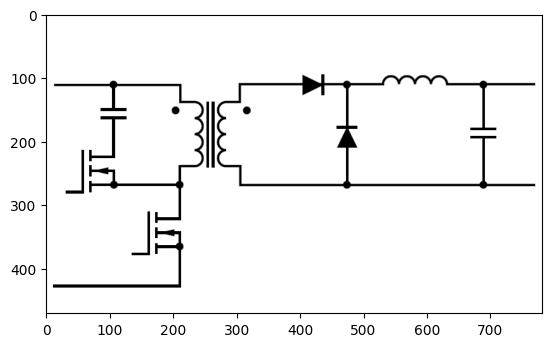

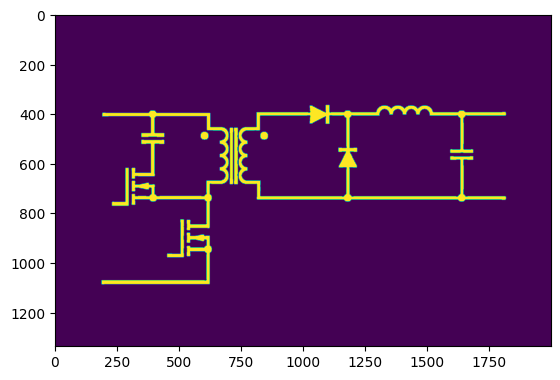

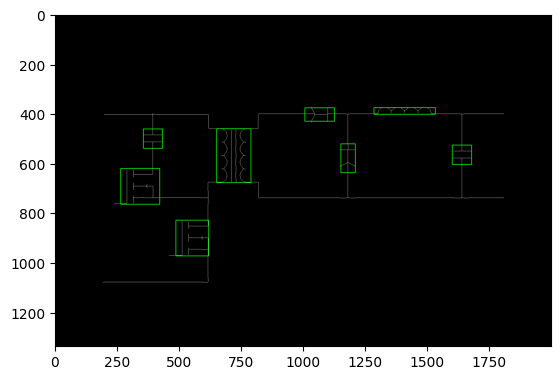

<ipython-input-1-ab0ae43f5b0a>:647: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  class_prediction = CLASS_NAMES[int(classes)]


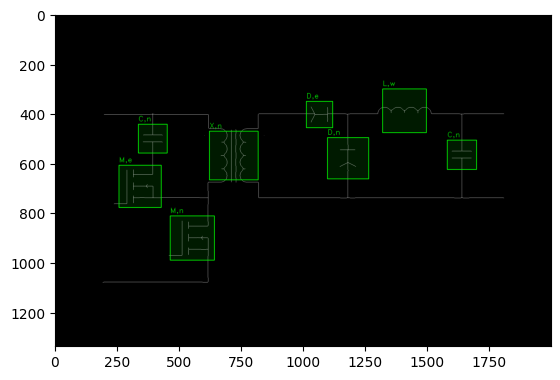

[[3. 3. 1. 0. 0. 0. 0. 2.]
 [0. 0. 1. 0. 0. 0. 0. 2.]
 [0. 0. 2. 0. 0. 1. 0. 0.]
 [0. 0. 2. 0. 0. 0. 1. 0.]
 [0. 0. 0. 2. 1. 0. 0. 0.]
 [0. 0. 2. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 2. 0. 1. 0.]
 [0. 0. 0. 0. 0. 2. 1. 0.]]
[[163. 163. 161.   0.   0.   0.   0. 162.]
 [  0.   0. 161.   0.   0.   0.   0. 162.]
 [  0.   0. 122.   0.   0. 121.   0.   0.]
 [  0.   0.  82.   0.   0.   0.  81.   0.]
 [  0.   0.   0. 122. 121.   0.   0.   0.]
 [  0.   0.  22.   0.  21.   0.   0.   0.]
 [  0.   0.   0.   0.  82.   0.  81.   0.]
 [  0.   0.   0.   0.   0. 102. 101.   0.]]


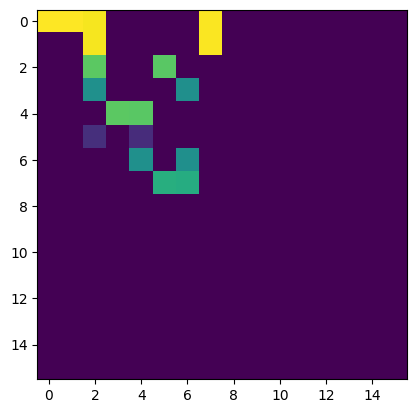

In [4]:
IMG_PATH='/content/gdrive/My Drive/Colab Notebooks/Minjie Chen/PowerVision/testset/'
images  = [f for f in os.listdir(IMG_PATH) if os.path.isfile(os.path.join(IMG_PATH, f))]
#images are file names
Image = np.random.randint(12, size=1)
#Image = 11
scheaddress = IMG_PATH+images[int(Image)]
#img = cv2.imread('sepic.png')
img, thres = img_proc(scheaddress)
skel, comp = find_all(img)
MODEL_PATH = '/content/gdrive/My Drive/Colab Notebooks/Minjie Chen/PowerVision/models/model.keras'
pre = classify(img, skel, comp, MODEL_PATH)
nodes = node_detect(thres, pre)
wiring_matrix, comp_matrix = matrix_gen(nodes, pre, img)
print(wiring_matrix)
indexmatrix = np.sign(wiring_matrix)
for i in range(len(comp_matrix)):
  if comp_matrix[i] == 'X':
    wiring_matrix[i,:] = (20+wiring_matrix[i,:])
  if comp_matrix[i] == 'I':
    wiring_matrix[i,:] = (40+wiring_matrix[i,:])
  if comp_matrix[i] == 'V':
    wiring_matrix[i,:] = (60+wiring_matrix[i,:])
  if comp_matrix[i] == 'D':
    wiring_matrix[i,:] = (80+wiring_matrix[i,:])
  if comp_matrix[i] == 'L':
    wiring_matrix[i,:] = (100+wiring_matrix[i,:])
  if comp_matrix[i] == 'C':
    wiring_matrix[i,:] = (120+wiring_matrix[i,:])
  if comp_matrix[i] == 'R':
    wiring_matrix[i,:] = (140+wiring_matrix[i,:])
  if comp_matrix[i] == 'M':
    wiring_matrix[i,:] = (160+wiring_matrix[i,:])
coded_matrix = np.multiply(wiring_matrix, indexmatrix)
print(coded_matrix)
delta_h = 16-coded_matrix.shape[0]
delta_w = 16-coded_matrix.shape[1]
reshaped_matrix = cv2.copyMakeBorder(coded_matrix,0,delta_h,0,delta_w,cv2.BORDER_CONSTANT,value=0)
plt.imshow(reshaped_matrix)

In [ ]:
NEW_MODEL_PATH = '/content/gdrive/My Drive/Colab Notebooks/Minjie Chen/PowerVision/models/classify_model.keras'